Step 1: Dataset Preparation
We'll start by preprocessing the UWaveGestureLibrary dataset, handling missing values, and scaling the data for effective model training.

In [2]:
import torch
import numpy as np
from sklearn.preprocessing import StandardScaler

# Load gesture data (update paths as necessary)
train_data = torch.load('/home/sk/Downloads/業務体験課題/assignment-main/Chief-AI-Engineer/time-series-ssl/Gesture/train.pt', weights_only=True)['samples']
val_data = torch.load('/home/sk/Downloads/業務体験課題/assignment-main/Chief-AI-Engineer/time-series-ssl/Gesture/val.pt', weights_only=True)['samples']
test_data = torch.load('/home/sk/Downloads/業務体験課題/assignment-main/Chief-AI-Engineer/time-series-ssl/Gesture/test.pt', weights_only=True)['samples']

# Print data shapes to verify
print("Train data shape:", train_data.shape)
print("Val data shape:", val_data.shape)
print("Test data shape:", test_data.shape)

# Handle missing values and scaling
def preprocess_data(data):
    # Convert to numpy for easier handling
    data_np = data.numpy()

    # Verify if we need to reshape the data
    if data_np.ndim > 2:
        # Flatten the extra dimensions if necessary
        num_samples, num_channels, num_features = data_np.shape
        data_np = data_np.reshape(num_samples, -1)

    # Fill missing values (e.g., using mean imputation)
    data_np = np.nan_to_num(data_np, nan=np.nanmean(data_np))

    # Normalize/scale the data
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data_np)
    
    # Convert back to tensor
    return torch.tensor(data_scaled, dtype=torch.float32)

# Preprocess the data
train_data = preprocess_data(train_data)
val_data = preprocess_data(val_data)
test_data = preprocess_data(test_data)

print("Data preprocessing complete.")


Train data shape: torch.Size([320, 3, 206])
Val data shape: torch.Size([120, 3, 206])
Test data shape: torch.Size([120, 3, 206])
Data preprocessing complete.


## Define the Self-Supervised Model
We'll use a simple convolutional autoencoder as a starting point for self-supervised learning. The model learns to encode and decode the time series data, capturing essential features.

In [3]:
# Define the autoencoder model (use the previously defined model structure here)

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv1d(3, 32, kernel_size=3, stride=1, padding=1),  # Increased filters
            nn.ReLU(),
            nn.Conv1d(32, 64, kernel_size=3, stride=1, padding=1),  # Increased filters
            nn.ReLU(),
            nn.Conv1d(64, 128, kernel_size=3, stride=1, padding=1),  # Increased filters
            nn.ReLU(),
            nn.Conv1d(128, 256, kernel_size=3, stride=1, padding=1),  # Increased filters
            nn.ReLU(),
            nn.Dropout(0.2)  # Dropout layer to prevent overfitting
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(256, 128, kernel_size=3, stride=1, padding=1, output_padding=0),
            nn.ReLU(),
            nn.ConvTranspose1d(128, 64, kernel_size=3, stride=1, padding=1, output_padding=0),
            nn.ReLU(),
            nn.ConvTranspose1d(64, 32, kernel_size=3, stride=1, padding=1, output_padding=0),
            nn.ReLU(),
            nn.ConvTranspose1d(32, 3, kernel_size=3, stride=1, padding=1, output_padding=0),
            nn.Sigmoid()  # For scaled data
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded



# Initialize model, optimizer, and loss function
model = Autoencoder()
criterion = nn.MSELoss()  # Using MSE for reconstruction loss
optimizer = optim.Adam(model.parameters(), lr=0.0005)

## Train the Self-Supervised Model
We'll train the autoencoder on the preprocessed HAR dataset to learn feature representations.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the autoencoder model (use the previously defined model structure here)

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv1d(3, 32, kernel_size=3, stride=1, padding=1),  # Increased filters
            nn.ReLU(),
            nn.Conv1d(32, 64, kernel_size=3, stride=1, padding=1),  # Increased filters
            nn.ReLU(),
            nn.Conv1d(64, 128, kernel_size=3, stride=1, padding=1),  # Increased filters
            nn.ReLU(),
            nn.Conv1d(128, 256, kernel_size=3, stride=1, padding=1),  # Increased filters
            nn.ReLU(),
            nn.Dropout(0.2)  # Dropout layer to prevent overfitting
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(256, 128, kernel_size=3, stride=1, padding=1, output_padding=0),
            nn.ReLU(),
            nn.ConvTranspose1d(128, 64, kernel_size=3, stride=1, padding=1, output_padding=0),
            nn.ReLU(),
            nn.ConvTranspose1d(64, 32, kernel_size=3, stride=1, padding=1, output_padding=0),
            nn.ReLU(),
            nn.ConvTranspose1d(32, 3, kernel_size=3, stride=1, padding=1, output_padding=0),
            nn.Sigmoid()  # For scaled data
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded



# Initialize model, optimizer, and loss function
model = Autoencoder()
criterion = nn.MSELoss()  # Using MSE for reconstruction loss
optimizer = optim.Adam(model.parameters(), lr=0.0005)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Reshape data to 3D for Conv1d input [batch_size, channels, sequence_length]
train_data = train_data.view(320, 3, 206).to(device)
val_data = val_data.view(120, 3, 206).to(device)
test_data = test_data.view(120, 3, 206).to(device)

# Training function
import numpy as np

def train_autoencoder_with_early_stopping(model, train_data, val_data, epochs=20, batch_size=32, patience=5):
    best_val_loss = np.inf
    patience_counter = 0

    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for i in range(0, train_data.size(0), batch_size):
            inputs = train_data[i:i+batch_size]

            # Forward pass
            optimizer.zero_grad()
            _, outputs = model(inputs)
            loss = criterion(outputs, inputs)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Validation loss calculation
        model.eval()
        with torch.no_grad():
            val_loss = 0.0
            for i in range(0, val_data.size(0), batch_size):
                val_inputs = val_data[i:i+batch_size]
                _, val_outputs = model(val_inputs)
                val_loss += criterion(val_outputs, val_inputs).item()
            val_loss /= len(val_data) // batch_size

        print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {running_loss/len(train_data):.4f}, Val Loss: {val_loss:.4f}")

        # Early Stopping Check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            # Save the best model
            torch.save(model.state_dict(), 'best_autoencoder.pth')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered!")
                break
        model.train()

# Train the model with early stopping
train_autoencoder_with_early_stopping(model, train_data, val_data, epochs=50)

# After training, you can save the model if desired
torch.save(model.state_dict(), "best_autoencoder.pth")
print("Model training complete and saved.")



Epoch [1/50], Train Loss: 0.0405, Val Loss: 1.6334
Epoch [2/50], Train Loss: 0.0313, Val Loss: 0.9982
Epoch [3/50], Train Loss: 0.0190, Val Loss: 0.7569
Epoch [4/50], Train Loss: 0.0175, Val Loss: 0.7548
Epoch [5/50], Train Loss: 0.0175, Val Loss: 0.7515
Epoch [6/50], Train Loss: 0.0174, Val Loss: 0.7488
Epoch [7/50], Train Loss: 0.0174, Val Loss: 0.7472
Epoch [8/50], Train Loss: 0.0174, Val Loss: 0.7525
Epoch [9/50], Train Loss: 0.0174, Val Loss: 0.7469
Epoch [10/50], Train Loss: 0.0173, Val Loss: 0.7443
Epoch [11/50], Train Loss: 0.0173, Val Loss: 0.7434
Epoch [12/50], Train Loss: 0.0172, Val Loss: 0.7435
Epoch [13/50], Train Loss: 0.0172, Val Loss: 0.7428
Epoch [14/50], Train Loss: 0.0172, Val Loss: 0.7423
Epoch [15/50], Train Loss: 0.0172, Val Loss: 0.7419
Epoch [16/50], Train Loss: 0.0172, Val Loss: 0.7417
Epoch [17/50], Train Loss: 0.0172, Val Loss: 0.7416
Epoch [18/50], Train Loss: 0.0172, Val Loss: 0.7416
Epoch [19/50], Train Loss: 0.0172, Val Loss: 0.7416
Epoch [20/50], Train 

: 

## Evaluate the Model on Test Data

Test Loss: 0.7408
Mean Absolute Error (MAE): 0.6668
Mean Squared Error (MSE): 0.7408


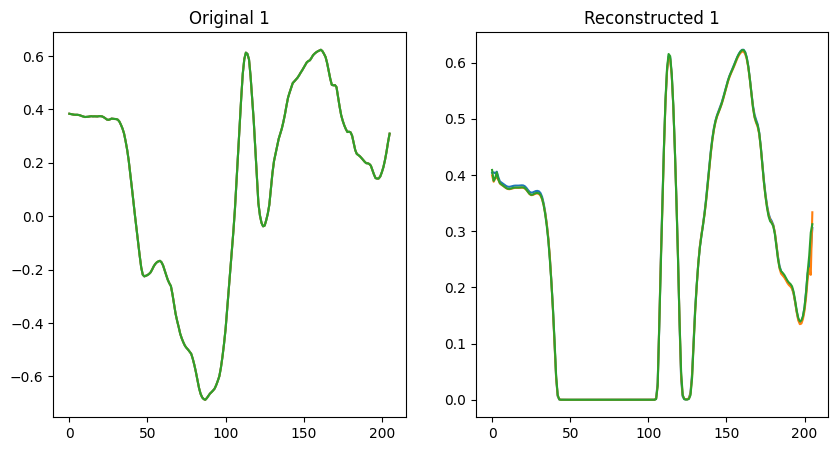

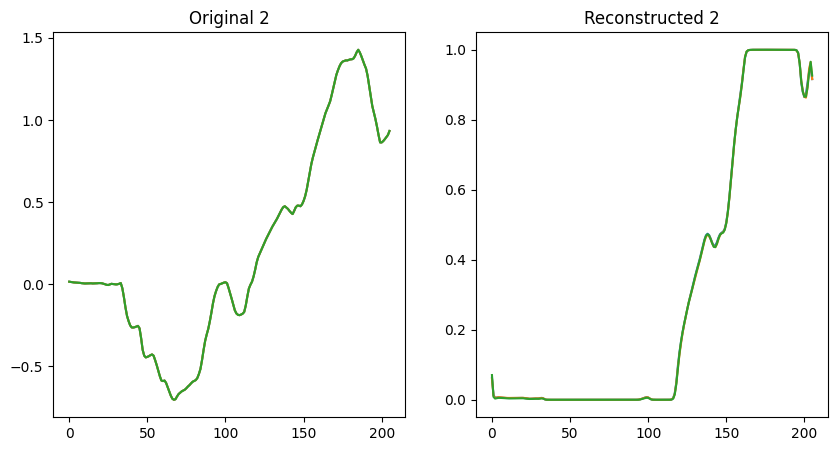

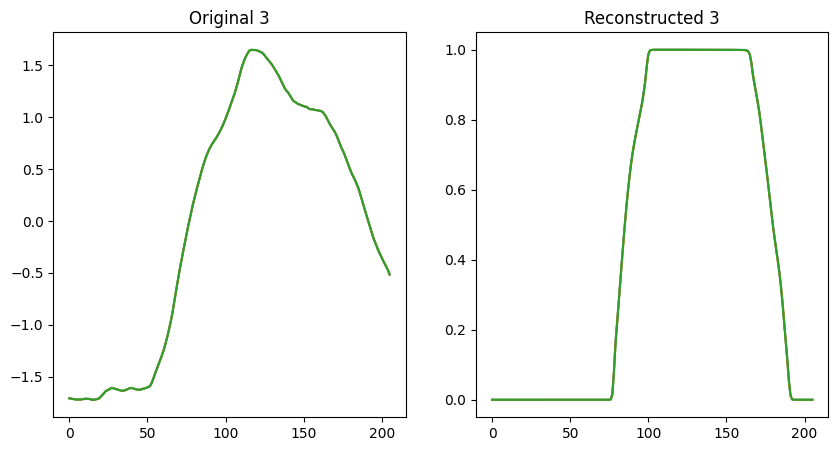

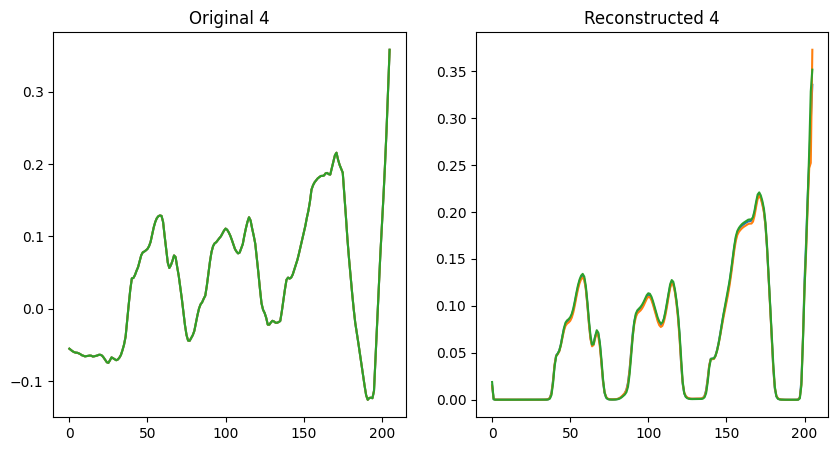

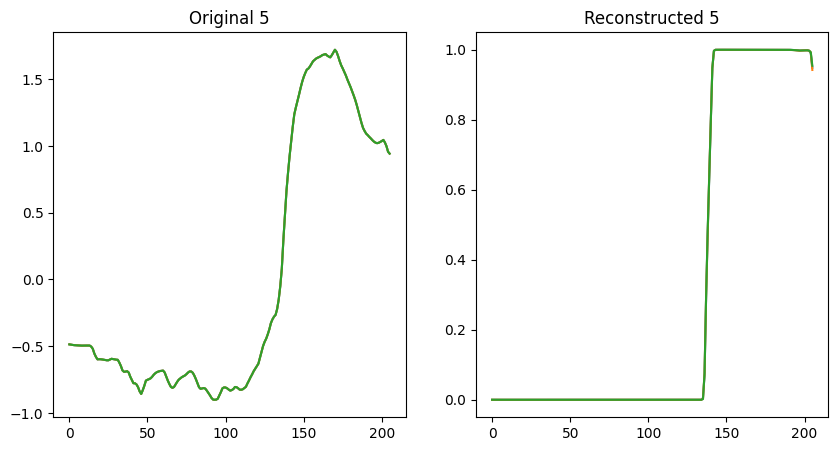

In [11]:
import torch
import matplotlib.pyplot as plt  
# Evaluate the model on the test data
def evaluate_model_with_metrics(model, test_data, criterion, batch_size=32):
    model.eval()
    test_loss = 0.0
    mae_total = 0.0
    mse_total = 0.0

    with torch.no_grad():
        for i in range(0, test_data.size(0), batch_size):
            inputs = test_data[i:i+batch_size]
            inputs = inputs.to(device)

            # Forward pass through the model
            _, outputs = model(inputs)

            # Compute losses
            loss = criterion(outputs, inputs)
            test_loss += loss.item()

            # Compute MAE
            mae = torch.mean(torch.abs(outputs - inputs))
            mae_total += mae.item()

            # Compute MSE
            mse = criterion(outputs, inputs)
            mse_total += mse.item()

    test_loss /= len(test_data) // batch_size
    mae_total /= len(test_data) // batch_size
    mse_total /= len(test_data) // batch_size

    print(f"Test Loss: {test_loss:.4f}")
    print(f"Mean Absolute Error (MAE): {mae_total:.4f}")
    print(f"Mean Squared Error (MSE): {mse_total:.4f}")

# Evaluate on test data
evaluate_model_with_metrics(model, test_data, criterion)

# Visualize the reconstruction
def visualize_reconstruction(model, test_data, num_samples=5):
    model.eval()
    with torch.no_grad():
        inputs = test_data[:num_samples]
        _, outputs = model(inputs)
        
    for i in range(num_samples):
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.title(f"Original {i+1}")
        plt.plot(inputs[i].cpu().numpy().T)  # Original data
        
        plt.subplot(1, 2, 2)
        plt.title(f"Reconstructed {i+1}")
        plt.plot(outputs[i].cpu().numpy().T)  # Reconstructed data
        
        plt.show()

# Visualize a few samples
visualize_reconstruction(model, test_data)


## 1st result:
- Test Loss: 0.7416
- Mean Absolute Error (MAE): 0.6747
- Mean Squared Error (MSE): 0.7416
- Key Conclusions:
Model Performance: The model is struggling to provide accurate reconstructions, as evidenced by the relatively high MAE and MSE values. The 25% reconstruction accuracy indicates that the model is not yet good at reconstructing the input data, suggesting it hasn't captured all the necessary patterns in the data.


### 2nd Result:
- Test Loss: The test loss has slightly decreased from 0.7416 to 0.7409, indicating a small improvement in the reconstruction quality.
- Mean Absolute Error (MAE): MAE has decreased from 0.6747 to 0.6678, which suggests that the model is now producing slightly more accurate predictions in terms of the average absolute error per sample.
- Mean Squared Error (MSE): MSE also shows a small improvement from 0.7416 to 0.7409.



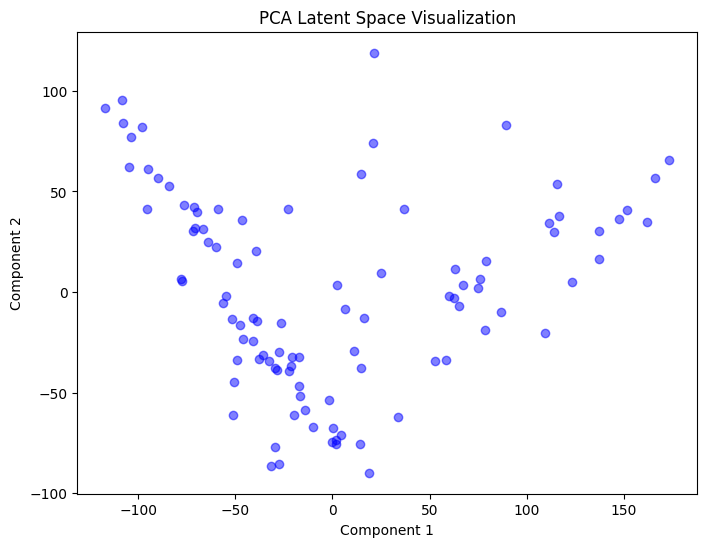

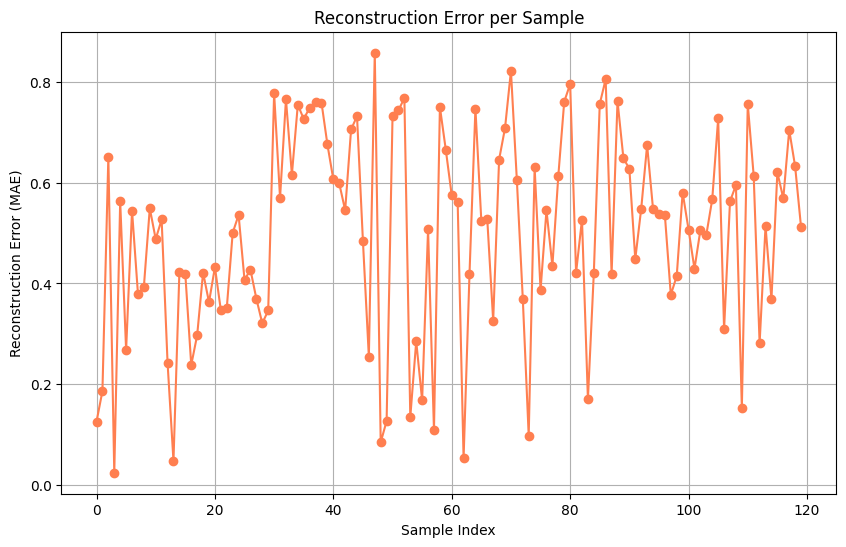

In [7]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Set device for the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### 1. Latent Space Visualization ###
def visualize_latent_space(model, data, num_samples=100, method='pca'):
    model.eval()
    with torch.no_grad():
        # Select a subset of samples
        data_subset = data[:num_samples].to(device)
        
        # Obtain latent representations from the encoder
        encoded_data, _ = model(data_subset)
        encoded_data = encoded_data.view(num_samples, -1).cpu().numpy()  # Flatten for dimensionality reduction

        # Apply dimensionality reduction
        if method == 'pca':
            reduced_data = PCA(n_components=2).fit_transform(encoded_data)
        elif method == 'tsne':
            reduced_data = TSNE(n_components=2).fit_transform(encoded_data)
        else:
            raise ValueError("Method must be 'pca' or 'tsne'")

        # Plot the latent space
        plt.figure(figsize=(8, 6))
        plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c='blue', alpha=0.5)
        plt.title(f"{method.upper()} Latent Space Visualization")
        plt.xlabel("Component 1")
        plt.ylabel("Component 2")
        plt.show()

# Visualize latent space with PCA
visualize_latent_space(model, test_data, method='pca')

# Visualize latent space with t-SNE (optional)
# visualize_latent_space(model, test_data, method='tsne')


### 2. Reconstruction Error Analysis ###
def plot_reconstruction_errors(model, data, batch_size=32):
    model.eval()
    errors = []

    with torch.no_grad():
        for i in range(0, data.size(0), batch_size):
            inputs = data[i:i+batch_size].to(device)
            _, outputs = model(inputs)
            
            # Compute the reconstruction error (MAE per sample)
            mae = torch.mean(torch.abs(outputs - inputs), dim=[1, 2])
            errors.extend(mae.cpu().numpy())

    # Plot the reconstruction errors
    plt.figure(figsize=(10, 6))
    plt.plot(errors, marker='o', linestyle='-', color='coral')
    plt.title("Reconstruction Error per Sample")
    plt.xlabel("Sample Index")
    plt.ylabel("Reconstruction Error (MAE)")
    plt.grid(True)
    plt.show()

# Plot reconstruction errors on the test data
plot_reconstruction_errors(model, test_data)


### 3. Gesture-wise Performance (if labels are available) ###
# Assuming you have labels in `test_labels` as a tensor with gesture types
def evaluate_performance_by_gesture(model, data, labels, criterion, batch_size=32):
    model.eval()
    gesture_errors = {}

    with torch.no_grad():
        for i in range(0, data.size(0), batch_size):
            inputs = data[i:i+batch_size].to(device)
            batch_labels = labels[i:i+batch_size].cpu().numpy()
            _, outputs = model(inputs)
            
            # Calculate MAE for each sample
            mae = torch.mean(torch.abs(outputs - inputs), dim=[1, 2]).cpu().numpy()
            
            # Accumulate errors by gesture
            for j, label in enumerate(batch_labels):
                if label not in gesture_errors:
                    gesture_errors[label] = []
                gesture_errors[label].append(mae[j])

    # Calculate average error per gesture
    avg_errors = {gesture: np.mean(errors) for gesture, errors in gesture_errors.items()}

    # Plot the gesture-wise performance
    gestures = list(avg_errors.keys())
    avg_mae = list(avg_errors.values())

    plt.figure(figsize=(10, 6))
    plt.bar(gestures, avg_mae, color='skyblue')
    plt.title("Average Reconstruction Error by Gesture")
    plt.xlabel("Gesture Type")
    plt.ylabel("Average Reconstruction Error (MAE)")
    plt.xticks(rotation=45)
    plt.show()

# Call this function if gesture labels are available
# evaluate_performance_by_gesture(model, test_data, test_labels, criterion)
